In [1]:
from __future__ import division

import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage.filters import median_filter

import tvdip
import mfblp

np.random.seed(42)
%matplotlib inline

%reload_ext autoreload
%autoreload 1

## Piecewise constant signal (PWC) denoising
This notebook provides examples of several different methods for denoising piecewise constant signals. The methods used are:
- moving average
- moving median
- moving median with conjugate laplace prior
- total variance scaling (a method seeking to jointly minimize the L-1 first differences of the smoothed signal $m$ and the L-2 squared residuals of the smoothed signal $m$ from the noisy signal $x$; see M.A. Little, Nick S. Jones (2010) "Sparse Bayesian Step-Filtering for High-Throughput Analysis of Molecular Machine Dynamics")

### Defining a nosiy signal $x$

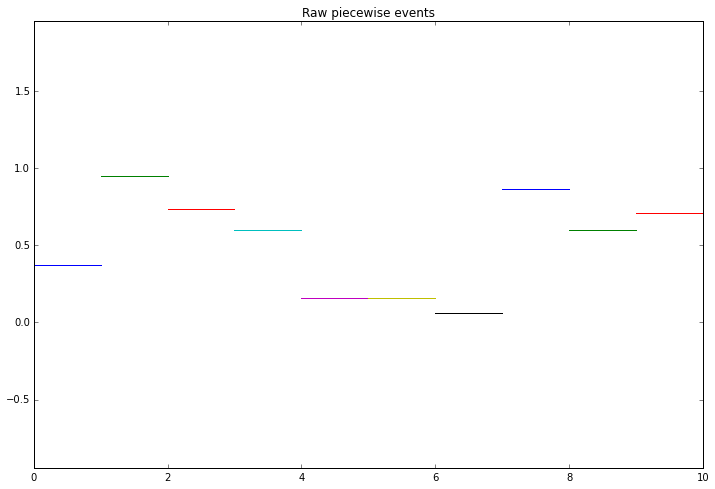

In [2]:
N = 10

xs = np.arange(N)
ys = np.random.rand(N)

plt.figure(figsize=(12,8), dpi=300)
plt.ylim([ys.min() - 1, ys.max() + 1])
for x,y in zip(xs, ys) :
    plt.plot([x,x+1],[y,y])
plt.title('Raw piecewise events')
plt.savefig('events.png')
plt.show()

In [3]:
sample_freq = 1000
noise_factor = 0.1

signal = np.array(sum([[y] * sample_freq for y in ys], []))
srange = signal.max() - signal.min()
noise = np.random.normal(0, srange * noise_factor, size=signal.shape)
nsignal = signal + noise

In [ ]:
plt.figure(figsize=(12,8), dpi=300)
plt.plot(signal, color='k', alpha=1.0, linewidth=2, label='True signal')
plt.plot(nsignal, color='b', alpha=0.1, linewidth=1, label='Noisy signal')
plt.legend()
plt.savefig('noised-events.png')
plt.show()

### Moving average

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

mov_avg_sizes = [3,5,15,35,71,141,299]
mov_avgs = map(lambda s : moving_average(nsignal, s), mov_avg_sizes)

plt.figure(figsize=(12,8),dpi=300)
plt.plot(nsignal, color='b', alpha=0.1, linewidth=1, label='Noisy signal')
plt.plot(signal, color='k', alpha=1.0, linewidth=2, label='True signal')
for ma, si in zip(mov_avgs, mov_avg_sizes) :
    plt.plot(ma, alpha=0.4, label='w={}'.format(si))
plt.legend(loc=2)
plt.savefig('mov_avg.png')
plt.show()

### Median filter

In [ ]:
median_sizes = [5,15,35,71,141,299]
medians = map(lambda s : median_filter(nsignal, s), median_sizes)

plt.figure(figsize=(12,8),dpi=300)
plt.plot(nsignal, color='b', alpha=0.1, linewidth=1, label='Noisy signal')
plt.plot(signal, color='k', alpha=1.0, linewidth=2, label='True signal')
for ma, si in zip(medians, median_sizes) :
    plt.plot(ma, alpha=0.4, label='w={}'.format(si))
plt.legend(loc=2)
plt.savefig('median_filter.png')
plt.show()

### Total variance denoising

In [ ]:
lambdas = np.array([1, 2, 10, 100, 1000])
x, E, s, lmax = tvdip.tvdip(nsignal.reshape(nsignal.shape[0], 1), lambdas, display=0, stoptol=1e-5, maxiter=100)
x = x.T

plt.figure(figsize=(12,8),dpi=300)
plt.plot(nsignal, color='b', alpha=0.1, linewidth=1, label='Noisy signal')
plt.plot(signal, color='k', alpha=0.8, linewidth=1, label='True signal')
for xi, lm in zip(x, lambdas) :
    plt.plot(xi, alpha=0.4, label='lambda={}'.format(lm))
plt.legend(loc=2)
plt.savefig('tvdip.png')
plt.show()

### Comparison of total variance denoising and moving average

In [ ]:
plt.figure(figsize=(12,8),dpi=300)
plt.plot(nsignal, color='b', alpha=0.1, linewidth=1, label='Noisy signal')
plt.plot(signal, color='k', alpha=0.8, linewidth=2, label='True signal')
plt.plot(mov_avgs[-2], alpha=0.8, linewidth=2, label='mov avg w={}'.format(mov_avg_sizes[-2]))
plt.plot(x[1], alpha=0.8, linewidth=2, label='TVS, l={}'.format(lambdas[1]))
plt.legend(loc=2)
plt.savefig('tvdip_movavg_compare.png')
plt.show()

In [ ]:
#'''Laplace prior median filter'''

def fit(x, w, s, a=0.1, b=10.0, numiter=2000) :
    '''
    paramters:
        x - ndarray; sparse signal to be filtered
        w - int; must be odd; window width
        s - ndarray; laplace prior locations
        a - float; strength of MAE vs. LP terms
        b - float; spread of laplace prior term
        numiter - int (optional); maximum number of search iterations

    returns :
        m - ndarray; best fit for filtered signal
    '''
    
    def roll_sum(m) :
        '''return an array of the cummulative absolute errors for the point
        estimate m of x_{w} for each window [x-hw, x+hw]'''
        return sum((np.abs(np.roll(x, i) - m) for i in xrange(-hw, hw + 1)))

    def get_likelihood(m) :
        '''return the negative log likelihood for mae-blp with estimate m
        with window size w'''
        difs = a * roll_sum(m)
        assert(difs.shape == x.shape)
        prior = np.exp(-b * np.abs(m[:,None] - s)).sum(axis=1)
        assert(prior.shape == x.shape)
        return difs - np.log(prior)

    def search(starts, stepsize, steps) :
        '''return optimal m from grid search given starting position and stepsize'''
        opt_ms = starts.copy()
        opt_ls = get_likelihood(starts)
        assert(opt_ms.shape == x.shape)
        assert(opt_ls.shape == x.shape)
        for iter in xrange(steps) :
            starts += stepsize
            ls = get_likelihood(starts)
            replace = ls < opt_ls
            opt_ms[replace] = starts[replace]
        return opt_ms
    
    assert(w % 2 == 1)
    hw = w // 2
    x = x.flatten()
    s = s.flatten()
    
    steps = numiter // 2
    maxv = max(x.max(), s.max())
    minv = min(x.min(), s.min())
    print maxv, minv
    first_stepsize = (maxv - minv) / steps
    first_starts = np.ones(x.shape) * minv
    second_stepsize = (first_stepsize * 2) / steps
    
    # first round, course search
    m = search(first_starts, first_stepsize, steps)
    # second round, fine search
    m = search(m - first_stepsize, second_stepsize, steps)
    return m

In [ ]:
mflp_sizes = [21]
f = mfblp.mfblp_filter(w=9, s=ys, a=0.1, b=10.0)
mflp = map(lambda w : mfblp.mfblp_filter(w=45, s=ys, a=0.5, b=10.0).apply(nsignal), mflp_sizes)

plt.figure(figsize=(12,8),dpi=300)
plt.plot(nsignal, color='b', alpha=0.1, linewidth=1, label='Noisy signal')
plt.plot(signal, color='k', alpha=1.0, linewidth=2, label='True signal')
for ma, si in zip(mflp, mflp_sizes) :
    plt.plot(ma, alpha=0.4, label='w={}'.format(si), c='red')
plt.legend(loc=2)
plt.savefig('median_filter_laplace_prior.png')

plt.show()

In [ ]:
x = np.array([1.25, 1.3, 1.3])
s = np.array([0.5, 1.0, 1.5])
f = mfblp.mfblp_filter(w=3, s=s, a=.1, b=10.0)

ms = np.linspace(0, 2, 1000)
ls = np.array(map(lambda m: f.get_likelihood(x, m * np.ones(3))[1], ms))

plt.plot(ms, ls)
plt.show()

In [ ]:
m = np.array([0.7, 1.1, 1.4])
p = m[:,None] - f.s
p = -.01 * np.abs(p)
p = np.exp(p).sum(axis=1)
p

In [ ]:
mflp_sizes = [21]
f = mfblp.mfblp_filter(w=9, s=ys, a=0.1, b=10.0)
mflp = map(lambda w : mfblp.mfblp_filter(w=45, s=ys, a=0.5, b=10.0).apply_restrict(nsignal), mflp_sizes)

plt.figure(figsize=(12,8),dpi=300)
plt.plot(nsignal, color='b', alpha=0.1, linewidth=1, label='Noisy signal')
plt.plot(signal, color='k', alpha=1.0, linewidth=2, label='True signal')
for ma, si in zip(mflp, mflp_sizes) :
    plt.plot(ma, alpha=0.4, label='w={}'.format(si), c='red')
plt.legend(loc=2)
#plt.savefig('median_filter_laplace_prior.png')

plt.show()

In [14]:
f = mfblp.mfblp_filter(w=9, s=ys, a=0.1, b=10.0)

%timeit f.apply_restrict(nsignal)

mae = np.average(
    map(lambda m: np.average(np.abs(m - signal)).sum(), 
        map(lambda x: f.apply_restrict(nsignal), xrange(20))
    )
)

print('MAE: {}'.format(mae))

10 loops, best of 3: 42.2 ms per loop
MAE: 0.0126274826276


In [15]:
f = mfblp.mfblp_filter(w=9, s=ys, a=0.1, b=10.0)

%timeit f.apply(nsignal)

mae = np.average(
    map(lambda m: np.average(np.abs(m - signal)).sum(), 
        map(lambda x: f.apply(nsignal), xrange(20))
    )
)

print('MAE: {}'.format(mae))

10 loops, best of 3: 183 ms per loop
MAE: 0.0765747716751


In [8]:
np.average(map(lambda m: np.average(np.abs(m - signal)).sum(), map(lambda x: f.apply(nsignal), xrange(10))))

0.076574771675118405

In [9]:
np.minimum

0.012627482627560624

In [ ]:
np.average